In [248]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
import copy

#### Data Reading and Import

In [249]:
raw_data = pd.read_excel("./Data/Data.xlsx", index_col = 0)
raw_data = raw_data.drop(['US Nominal Yield'], axis=1)

In [250]:
raw_data.columns

Index(['Industrial Metal', 'Bond', 'DM EQ', 'Cash', 'Inflation', 'Growth',
       'Value', 'Small', 'Big', 'Weak', 'Resilient', 'Real GDP Growth', 'Gold',
       'NoDur', 'Durbl', 'Manuf', 'Enrgy', 'HiTec', 'Telcm', 'Shops', 'Hlth ',
       'Utils', 'Other', 'EM EQ', 'REITs', 'Change in Nominal Yield',
       'Change in Real Yield'],
      dtype='object')

In [251]:
annualized_raw_data_first_part = (raw_data.iloc[:, :-2] + 1).rolling(12).apply(np.prod)-1
annualized_raw_data_second_part = (raw_data.iloc[:,-2:]).rolling(12).sum()
annualized_raw_data = annualized_raw_data_first_part.join(annualized_raw_data_second_part)

In [252]:
processed_monthly_data = copy.deepcopy(raw_data)
processed_annual_data = copy.deepcopy(annualized_raw_data)

#### Inflation Regime Identification

<AxesSubplot:ylabel='Frequency'>

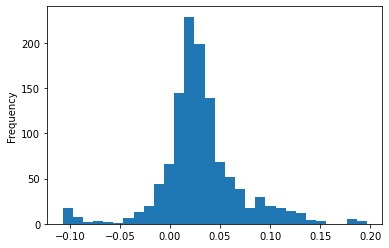

In [253]:
# Inflation
annualized_raw_data['Inflation'].plot.hist(bins = 30)

In [254]:
raw_data_inflation = annualized_raw_data['Inflation'].dropna().values
reshaped_inflation = raw_data_inflation.reshape(raw_data_inflation.shape[0], 1)
inflation_model = hmm.GaussianHMM(n_components=3, n_iter=4000, random_state=2010).fit(reshaped_inflation)
mus = np.ravel(inflation_model.means_)
sigmas = np.ravel(np.sqrt([np.diag(c) for c in inflation_model.covars_]))
P = inflation_model.transmat_
print(mus, sigmas)
print(P)

[ 0.08132988  0.0235938  -0.02828896] [0.03250934 0.01200772 0.03588013]
[[9.73432959e-01 2.65670414e-02 1.48860480e-18]
 [1.10561627e-02 9.81540202e-01 7.40363559e-03]
 [9.54356650e-15 3.52563392e-02 9.64743661e-01]]


In [255]:
inflation_regime_state = inflation_model.predict(reshaped_inflation)
inflation_regime_state[inflation_regime_state == 2] = -2
inflation_regime_state[inflation_regime_state == 0] = 2
inflation_regime_state[inflation_regime_state == 1] = 0
processed_annual_data.loc[processed_annual_data['Inflation'].dropna().index,"Inflation Regime"] = inflation_regime_state

#### Real GDP Regime Identification

<AxesSubplot:ylabel='Frequency'>

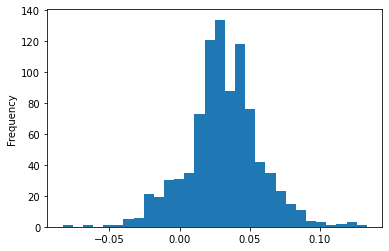

In [256]:
# Real GDP Growth
annualized_raw_data['Real GDP Growth'].plot.hist(bins = 30)

In [257]:
raw_data_real_gdp_growth = annualized_raw_data['Real GDP Growth'].dropna().values
reshaped_real_gdp_growth = raw_data_real_gdp_growth.reshape(raw_data_real_gdp_growth.shape[0], 1)
gdp_model = hmm.GaussianHMM(n_components=3, n_iter=4000, random_state=2010).fit(reshaped_real_gdp_growth)
mus = np.ravel(gdp_model.means_)
sigmas = np.ravel(np.sqrt([np.diag(c) for c in gdp_model.covars_]))
P = gdp_model.transmat_
print(mus, sigmas)
print(P)

[-0.00882353  0.0252367   0.05517811] [0.01754744 0.00937592 0.01777003]
[[9.17265684e-01 8.12614236e-02 1.47289216e-03]
 [3.04069089e-02 9.33797390e-01 3.57957013e-02]
 [4.47978065e-10 4.41636722e-02 9.55836327e-01]]


In [258]:
gdp_regime_state = gdp_model.predict(reshaped_real_gdp_growth)
gdp_regime_state[gdp_regime_state == 0] = -2
gdp_regime_state[gdp_regime_state == 1] = 0
gdp_regime_state[gdp_regime_state == 2] = 2
processed_annual_data.loc[processed_annual_data['Real GDP Growth'].dropna().index,"Growth Regime"] = gdp_regime_state

#### Real Yield Regime Identification

<AxesSubplot:ylabel='Frequency'>

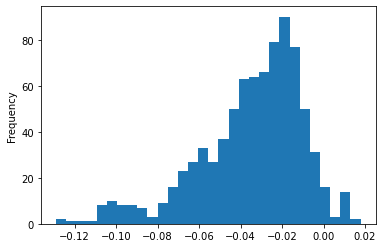

In [259]:
# Real Yield Change
annualized_raw_data['Change in Real Yield'].plot.hist(bins = 30)

In [260]:
raw_data_real_yield_change = annualized_raw_data['Change in Real Yield'].dropna().values
reshaped_real_yield_change = raw_data_real_yield_change.reshape(raw_data_real_yield_change.shape[0], 1)
yield_model = hmm.GaussianHMM(n_components=3, n_iter=10000, random_state=2000).fit(reshaped_real_yield_change)
mus = np.ravel(yield_model.means_)
sigmas = np.ravel(np.sqrt([np.diag(c) for c in yield_model.covars_]))
P = yield_model.transmat_
print(mus, sigmas)
print(P)

[-0.03926962 -0.01482657 -0.07506845] [0.01073948 0.01074386 0.02002051]
[[9.43286226e-01 4.10867748e-02 1.56269995e-02]
 [3.44723211e-02 9.65527679e-01 3.19875244e-72]
 [2.79631243e-02 4.35635094e-32 9.72036876e-01]]


In [261]:
real_yield_state = yield_model.predict(reshaped_real_yield_change)
real_yield_state[real_yield_state == 2] = -2
real_yield_state[real_yield_state == 0] = 0
real_yield_state[real_yield_state == 1] = 2
processed_annual_data.loc[processed_annual_data['Change in Real Yield'].dropna().index,"Yield Regime"] = real_yield_state

In [262]:
processed_annual_data.to_excel("Macro Regime.xlsx")

#### Macro Regime Visualisation

<AxesSubplot:>

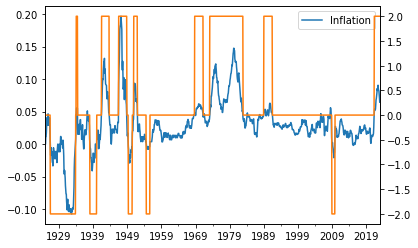

In [263]:
# Inflation Regime Visualisation
inflation_data_for_visualization = processed_annual_data.loc[:,["Inflation", "Inflation Regime"]].dropna()
inflation_data_for_visualization.plot(y = 'Inflation')
inflation_data_for_visualization['Inflation Regime'].plot(secondary_y = True)

<AxesSubplot:>

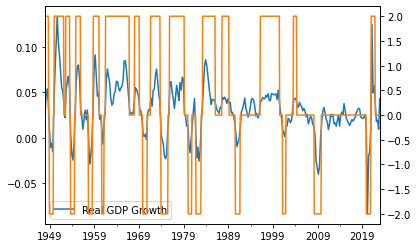

In [264]:
# Growth Regime Visualisation
growth_data_for_visualization = processed_annual_data.loc[:,["Real GDP Growth", "Growth Regime"]].dropna()
growth_data_for_visualization.plot(y = 'Real GDP Growth')
growth_data_for_visualization['Growth Regime'].plot(secondary_y = True)

<AxesSubplot:>

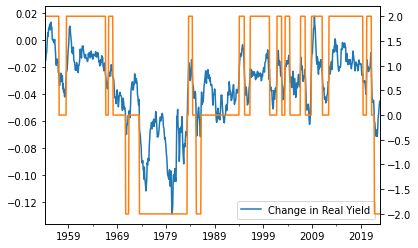

In [265]:
# Real Yield Regime Visualisation
real_yield_data_for_visualization = processed_annual_data.loc[:,["Change in Real Yield", "Yield Regime"]].dropna()
real_yield_data_for_visualization.plot(y = 'Change in Real Yield')
real_yield_data_for_visualization['Yield Regime'].plot(secondary_y = True)

In [270]:
asset_classes = processed_annual_data.iloc[:, : -5].columns.tolist()

#### Asset Class Performances based on Different Regimes

<AxesSubplot:>

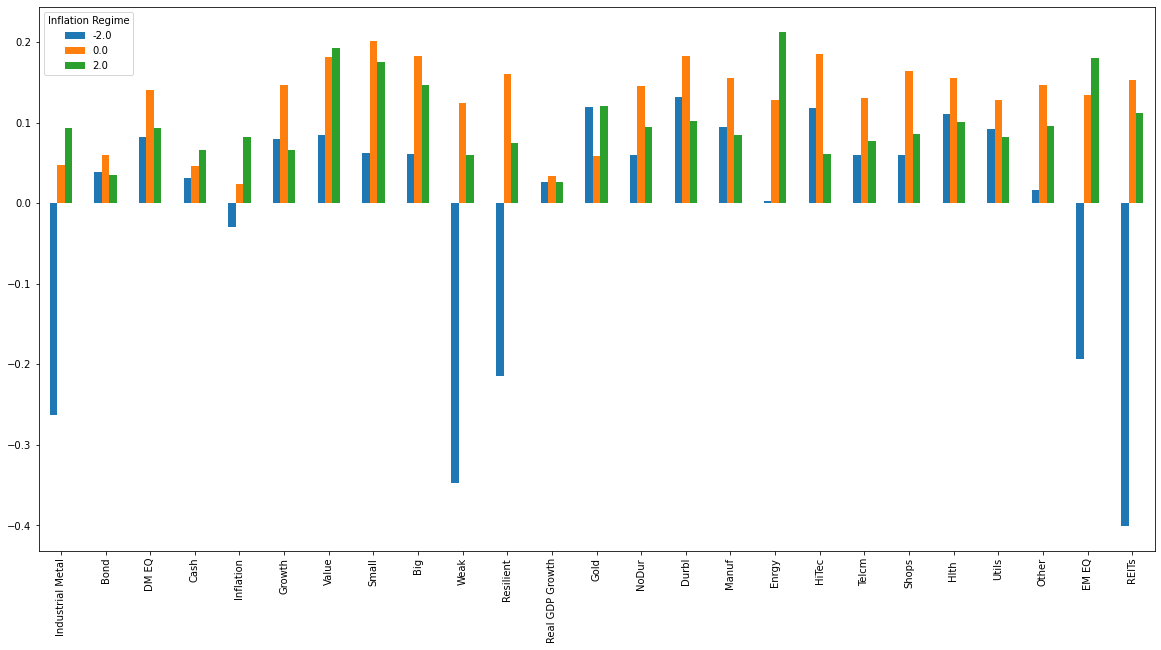

In [283]:
processed_annual_data.loc[:, asset_classes + ["Inflation Regime"]].groupby('Inflation Regime').mean().transpose().plot.bar(figsize = (20,10))

<AxesSubplot:>

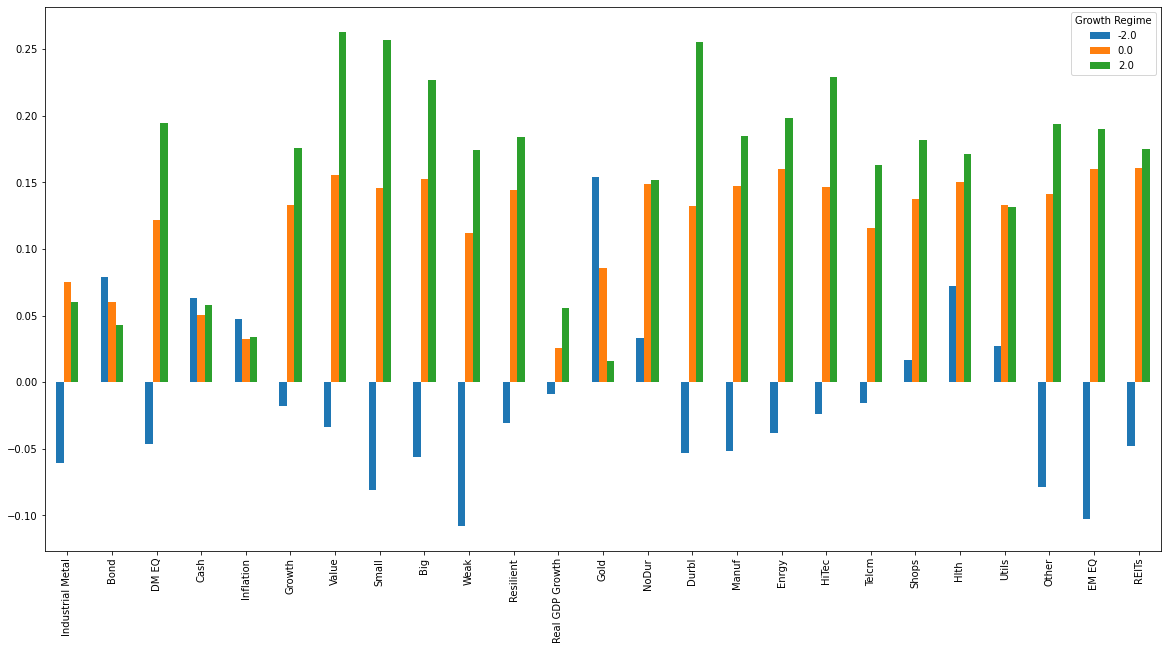

In [284]:
processed_annual_data.loc[:, asset_classes + ["Growth Regime"]].groupby('Growth Regime').mean().transpose().plot.bar(figsize = (20,10))

<AxesSubplot:>

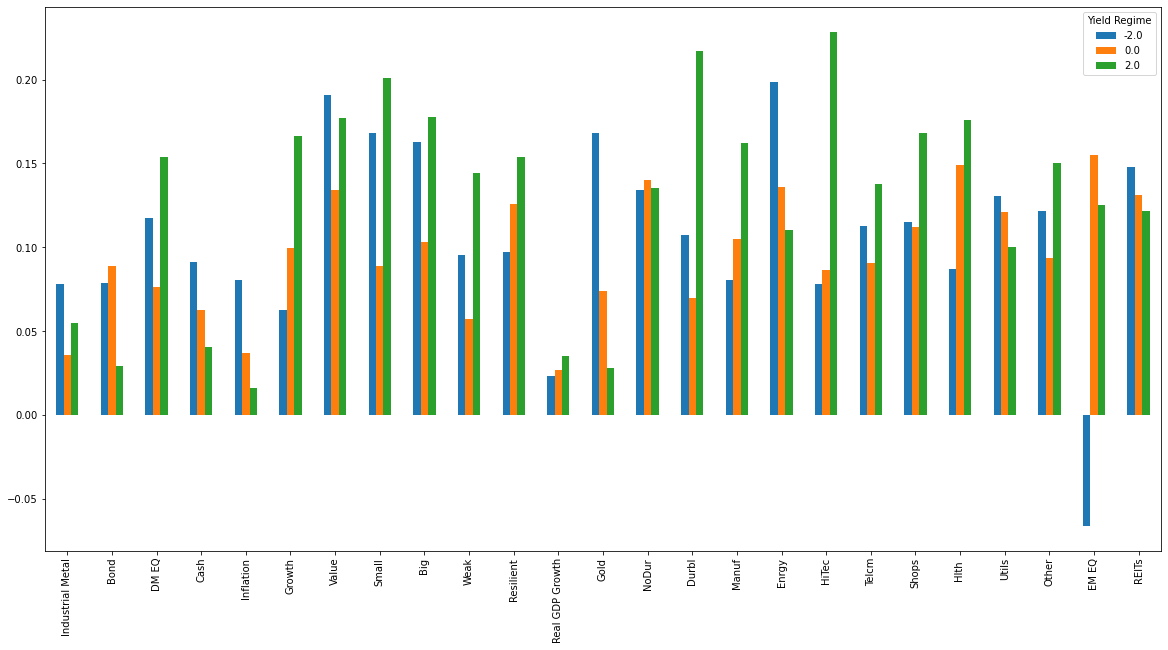

In [285]:
processed_annual_data.loc[:, asset_classes + ["Yield Regime"]].groupby('Yield Regime').mean().transpose().plot.bar(figsize = (20,10))